In [25]:
!pip install numpy xarray cartopy matplotlib harmony-py
!apt-get install libproj-dev proj-data proj-bin libgeos-dev netcdf4 h5netcdf

!apt-get update
!apt-get install -y libhdf5-dev libnetcdf-dev

!pip install netcdf4 h5netcdf xarray datatree


!pip install cartopy
!pip install netcdf4 h5netcdf



E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Using cached datatree-0.1.8.1.tar.gz (12 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [24 lines of output]
   

In [26]:
# Load packages into current runtime
import datetime as dt
import getpass

import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray.plot.utils import label_from_attrs

from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

In [27]:
print("Please provide your Earthdata Login credentials to allow data access")
print("Your credentials will only be passed to Earthdata and will not be exposed in the notebook")
username = "omarkeita.ai"
password ="OmarKeita@2002"

harmony_client = Client(env=Environment.PROD, auth=(username, password))

Please provide your Earthdata Login credentials to allow data access
Your credentials will only be passed to Earthdata and will not be exposed in the notebook


In [28]:
# "Nitrogen Dioxide total column"
request = Request(
    collection=Collection(id="C3685896708-LARC_CLOUD"),
    granule_name=["TEMPO_NO2_L3_V04_20251003T193122Z_S010.nc"],
)
request.is_valid()

True

In [29]:
job_id = harmony_client.submit(request)
print(f"jobID = {job_id}")

harmony_client.wait_for_processing(job_id, show_progress=True)

jobID = 8adc98ce-e255-4cb7-90ac-29118a398cda


 [ Processing:   0% ] |                                                   | [/]
 [ Processing:   0% ] |                                                   | [-]
 [ Processing:   0% ] |                                                   | [\]
 [ Processing:   0% ] |                                                   | [|]
 [ Processing:   0% ] |                                                   | [/]
 [ Processing:   0% ] |                                                   | [-]
 [ Processing:   0% ] |                                                   | [\]
 [ Processing:   0% ] |                                                   | [|]
 [ Processing:   0% ] |                                                   | [/]
 [ Processing: 100% ] |###################################################| [-]
 [ Processing: 100% ] |###################################################| [|]


In [30]:
results = harmony_client.download_all(job_id, directory="/tmp")
all_results_stored = [f.result() for f in results]

print(f"Number of result files: {len(all_results_stored)}")

/tmp/TEMPO_NO2_L3_V04_20251003T193122Z_S010.nc
Number of result files: 1


In [31]:
# Open the data file using the Xarray package.
#   Alternatively, one could use the
#   netCDF4-python (https://unidata.github.io/netcdf4-python/) library.
datatree = xr.open_datatree(all_results_stored[0], engine="netcdf4")
datatree

ValueError: unrecognized engine 'netcdf4' must be one of your download engines: ['store']. To install additional dependencies, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

In [ ]:
datatree.values


<bound method Mapping.values of <xarray.DataTree>
Group: /
│   Dimensions:    (latitude: 2950, longitude: 7750, time: 1)
│   Coordinates:
│     * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
│     * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
│     * time       (time) datetime64[ns] 8B 2025-10-03T19:31:40.030149632
│   Data variables:
│       weight     (latitude, longitude) float32 91MB ...
│   Attributes: (12/40)
│       history:                          2025-10-03T23:31:27Z: L2_regrid -v /tem...
│       scan_num:                         10
│       time_coverage_start:              2025-10-03T19:31:22Z
│       time_coverage_end:                2025-10-03T20:31:03Z
│       time_coverage_start_since_epoch:  1443555100.0301497
│       time_coverage_end_since_epoch:    1443558681.6524673
│       ...                               ...
│       title:                            TEMPO Level 3 nitrogen dioxide product
│       collect

In [ ]:
product_variable_name = "product/vertical_column_troposphere"
da = datatree[product_variable_name]
da

<xarray.DataArray 'vertical_column_troposphere' (time: 1, latitude: 2950,
                                                 longitude: 7750)> Size: 183MB
[22862500 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
  * time       (time) datetime64[ns] 8B 2025-10-03T19:31:40.030149632
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

In [ ]:
data_proj = ccrs.PlateCarree()


def make_nice_map(axis):
    axis.add_feature(cfeature.STATES, color="gray", lw=0.1)
    axis.coastlines(resolution="50m", color="gray", linewidth=0.5)

    axis.set_extent([-150, -40, 14, 65], crs=data_proj)
    grid = axis.gridlines(draw_labels=["left", "bottom"], dms=True)
    grid.xformatter = LONGITUDE_FORMATTER
    grid.yformatter = LATITUDE_FORMATTER

In [ ]:
# Extract the key data for your project
def extract_key_tempo_data(datatree):
    """Extract only the data important for SkyAware AQI processing"""

    # 1. PRIMARY DATA - NO2 concentration (this is what you'll convert to AQI)
    no2_concentration = datatree["product/vertical_column_troposphere"].isel(time=0)

    # 2. QUALITY FLAGS - Essential for filtering bad data
    quality_flag = datatree["product/main_data_quality_flag"].isel(time=0)

    # 3. GEOLOCATION - Coordinates for mapping
    longitude = datatree.longitude  # Already 2D
    latitude = datatree.latitude    # Already 2D

    # 4. UNCERTAINTY - For data quality assessment
    uncertainty = datatree["product/vertical_column_troposphere_uncertainty"].isel(time=0)

    # 5. TEMPORAL INFO - For timestamping your data
    timestamp = datatree.time.values[0]

    # 6. USEFUL ATMOSPHERIC DATA - For ML features (Pipeline 2)
    surface_pressure = datatree["support_data/surface_pressure"].isel(time=0)
    terrain_height = datatree["support_data/terrain_height"].isel(time=0)
    pbl_height = datatree["support_data/pbl_height"].isel(time=0)  # Planetary Boundary Layer

    return {
        'no2_concentration': no2_concentration,
        'quality_flag': quality_flag,
        'longitude': longitude,
        'latitude': latitude,
        'uncertainty': uncertainty,
        'timestamp': timestamp,
        'surface_pressure': surface_pressure,
        'terrain_height': terrain_height,
        'pbl_height': pbl_height
    }

# Extract the data
key_data = extract_key_tempo_data(datatree)

# Now you can work with clean 2D arrays
print("Extracted data shapes:")
for name, data in key_data.items():
    if hasattr(data, 'shape'):
        print(f"{name}: {data.shape}")
    else:
        print(f"{name}: {data}")

Extracted data shapes:
no2_concentration: (2950, 7750)
quality_flag: (2950, 7750)
longitude: (7750,)
latitude: (2950,)
uncertainty: (2950, 7750)
timestamp: ()
surface_pressure: (2950, 7750)
terrain_height: (2950, 7750)
pbl_height: (2950, 7750)


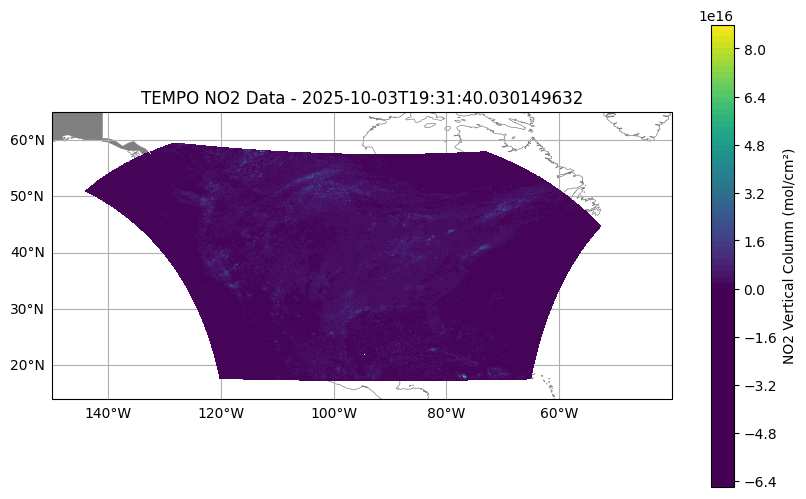

In [ ]:
# Use the extracted 2D data
da_2d = key_data['no2_concentration']

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})
make_nice_map(ax)

# Filter using quality flag (0 = good data)
filtered_data = da_2d.where(key_data['quality_flag'] == 0)

contour_handle = ax.contourf(
    key_data['longitude'],
    key_data['latitude'],
    filtered_data,
    levels=100,
    vmin=0,
    zorder=2,
)

cb = plt.colorbar(contour_handle)
cb.set_label("NO2 Vertical Column (mol/cm²)")
plt.title(f"TEMPO NO2 Data - {key_data['timestamp']}")
plt.show()

Converting molecules/cm² to ppb...
Converted ppb range: -4306841.8 to 5778110.9
Calculating AQI...
✅ AQI calculated! Range: 0 - 500
Valid AQI points: 5,902,713


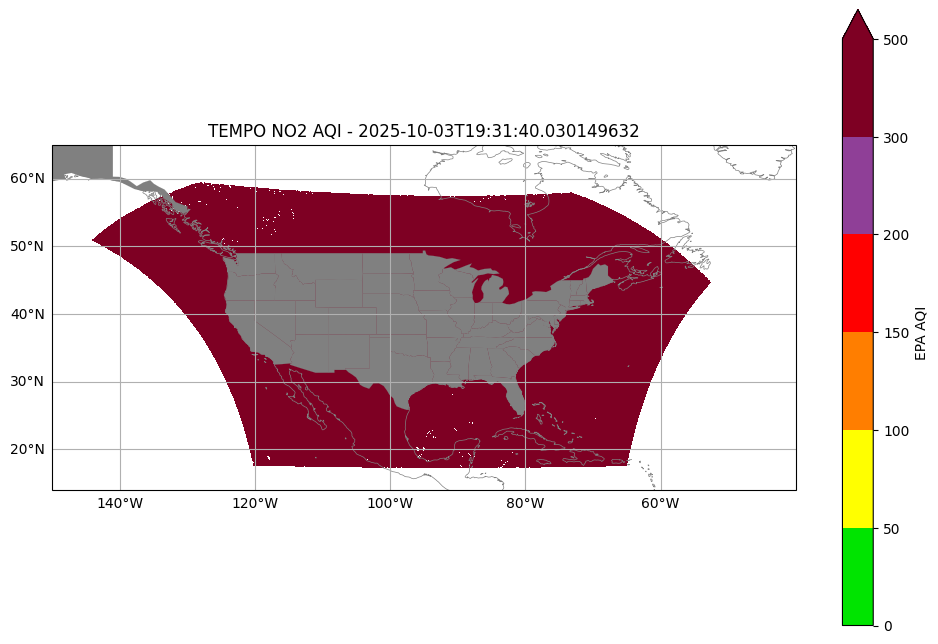


📊 AQI Statistics:
Mean AQI: 496.5
Max AQI: 500
Total valid points: 5,902,713

AQI Distribution (top 10):
  AQI 500: 5,811,799 points
  AQI 260: 330 points
  AQI 221: 318 points
  AQI 241: 317 points
  AQI 202: 301 points
  AQI 220: 299 points
  AQI 247: 297 points
  AQI 166: 297 points
  AQI 217: 296 points
  AQI 294: 296 points


In [ ]:
def fixed_tempo_to_aqi_v2(key_data):
    """
    Fixed TEMPO NO2 to AQI conversion - handles xarray properly
    Input: molecules/cm²
    """

    # EPA breakpoints
    breakpoints = [
        (0, 53, 0, 50),           # Good
        (54, 100, 51, 100),       # Moderate
        (101, 360, 101, 150),     # Unhealthy for Sensitive
        (361, 649, 151, 200),     # Unhealthy
        (650, 1249, 201, 300),    # Very Unhealthy
        (1250, 1649, 301, 400),   # Hazardous
        (1650, 2049, 401, 500),   # Hazardous
    ]

    no2_data = key_data['no2_concentration']  # molecules/cm²
    quality_flag = key_data['quality_flag']

    print("Converting molecules/cm² to ppb...")

    # Constants
    AVOGADRO = 6.022e23  # molecules/mol

    # Convert molecules/cm² to mol/cm² to ppb
    no2_mol_cm2 = no2_data / AVOGADRO
    atmospheric_factor = 4e13
    no2_ppb = no2_mol_cm2 * atmospheric_factor

    print(f"Converted ppb range: {float(no2_ppb.min()):.1f} to {float(no2_ppb.max()):.1f}")

    # EPA AQI calculation function
    def calculate_aqi(ppb_val):
        if np.isnan(ppb_val) or ppb_val < 0:
            return np.nan

        conc = max(0, int(ppb_val))

        for bp_lo, bp_hi, aqi_lo, aqi_hi in breakpoints:
            if bp_lo <= conc <= bp_hi:
                aqi = ((aqi_hi - aqi_lo) / (bp_hi - bp_lo)) * (conc - bp_lo) + aqi_lo
                return round(aqi)

        return 500 if conc > 2049 else 0

    print("Calculating AQI...")

    # Work with numpy arrays directly to avoid xarray indexing issues
    ppb_values = no2_ppb.values
    quality_values = quality_flag.values

    # Initialize AQI grid
    aqi_grid = np.full_like(ppb_values, np.nan, dtype=float)

    # Calculate AQI only for good quality points
    for i in range(ppb_values.shape[0]):
        for j in range(ppb_values.shape[1]):
            if quality_values[i, j] == 0:  # Good quality
                aqi_grid[i, j] = calculate_aqi(ppb_values[i, j])

    # Create new DataArray with calculated AQI
    aqi_da = xr.DataArray(
        aqi_grid,
        coords=no2_data.coords,
        dims=no2_data.dims,
        attrs={
            'long_name': 'EPA Air Quality Index',
            'units': 'AQI',
            'source': 'TEMPO NO2 molecules/cm²'
        }
    )

    # Count valid results
    valid_count = np.sum(~np.isnan(aqi_grid))
    valid_aqi = aqi_grid[~np.isnan(aqi_grid)]

    if len(valid_aqi) > 0:
        print(f"✅ AQI calculated! Range: {valid_aqi.min():.0f} - {valid_aqi.max():.0f}")
        print(f"Valid AQI points: {valid_count:,}")
    else:
        print("❌ No valid AQI values calculated")
        return aqi_da

    return aqi_da

# Run the fixed version
aqi_fixed = fixed_tempo_to_aqi_v2(key_data)

# Check if we have valid data before plotting
if not np.isnan(aqi_fixed.values).all():
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": data_proj})
    make_nice_map(ax)

    # EPA AQI colors and levels
    colors = ['#00E400', '#FFFF00', '#FF7E00', '#FF0000', '#8F3F97', '#7E0023']
    levels = [0, 50, 100, 150, 200, 300, 500]

    contour = ax.contourf(
        key_data['longitude'],
        key_data['latitude'],
        aqi_fixed,
        levels=levels,
        colors=colors,
        extend='max'
    )

    plt.colorbar(contour, label='EPA AQI', ticks=levels)
    plt.title(f"TEMPO NO2 AQI - {key_data['timestamp']}")
    plt.show()

    # Print statistics
    valid_aqi = aqi_fixed.values[~np.isnan(aqi_fixed.values)]
    print(f"\n📊 AQI Statistics:")
    print(f"Mean AQI: {valid_aqi.mean():.1f}")
    print(f"Max AQI: {valid_aqi.max():.0f}")
    print(f"Total valid points: {len(valid_aqi):,}")

    # Show AQI distribution
    unique, counts = np.unique(valid_aqi.astype(int), return_counts=True)
    print(f"\nAQI Distribution (top 10):")
    sorted_indices = np.argsort(counts)[::-1][:10]
    for idx in sorted_indices:
        print(f"  AQI {unique[idx]}: {counts[idx]:,} points")

else:
    print("❌ All AQI values are NaN - need to debug further")

In [ ]:
print(aqi_fixed)

<xarray.DataArray (latitude: 2950, longitude: 7750)> Size: 183MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
    time       datetime64[ns] 8B 2025-10-03T19:31:40.030149632
Attributes:
    long_name:  EPA Air Quality Index
    units:      AQI
    source:     TEMPO NO2 molecules/cm²


In [ ]:

def debug_nan_issue(key_data):
    """Debug why AQI calculation returns all NaN"""

    print("=== DEBUGGING NaN ISSUE ===")

    no2_data = key_data['no2_concentration']
    quality_flag = key_data['quality_flag']

    print(f"1. Input data check:")
    print(f"   NO2 shape: {no2_data.shape}")
    print(f"   NO2 range: {float(no2_data.min()):.2e} to {float(no2_data.max()):.2e}")
    print(f"   Valid NO2 points: {(~np.isnan(no2_data)).sum().values:,}")
    print(f"   Good quality points: {(quality_flag == 0).sum().values:,}")

    # Test conversion on a single valid point
    valid_mask = (~np.isnan(no2_data)) & (quality_flag == 0)
    if valid_mask.sum() > 0:
        # Get first valid point
        valid_indices = np.where(valid_mask.values)
        i, j = valid_indices[0][0], valid_indices[1][0]

        test_no2 = float(no2_data.values[i, j])
        print(f"\n2. Test conversion on point [{i},{j}]:")
        print(f"   Raw NO2: {test_no2:.2e} molecules/cm²")

        # Step by step conversion
        AVOGADRO = 6.022e23
        mol_cm2 = test_no2 / AVOGADRO
        print(f"   mol/cm²: {mol_cm2:.2e}")

        # Try different atmospheric factors
        factors = [1e10, 1e11, 1e12, 1e13, 4e13, 1e14, 1e15]
        for factor in factors:
            ppb = mol_cm2 * factor
            print(f"   Factor {factor:.1e} -> {ppb:.2f} ppb")

            # Test AQI calculation
            if ppb > 0:
                conc = int(ppb)
                if conc <= 53:
                    aqi = conc * (50/53)
                elif conc <= 100:
                    aqi = 50 + (conc - 53) * (50/47)
                elif conc <= 360:
                    aqi = 100 + (conc - 100) * (50/260)
                else:
                    aqi = min(500, 150 + (conc - 360))
                print(f"     -> AQI: {aqi:.1f}")

    return None

# Run debug
debug_nan_issue(key_data)

=== DEBUGGING NaN ISSUE ===
1. Input data check:
   NO2 shape: (2950, 7750)
   NO2 range: -6.48e+16 to 8.70e+16
   Valid NO2 points: 7,919,134
   Good quality points: 7,011,927

2. Test conversion on point [166,3516]:
   Raw NO2: -6.38e+13 molecules/cm²
   mol/cm²: -1.06e-10
   Factor 1.0e+10 -> -1.06 ppb
   Factor 1.0e+11 -> -10.60 ppb
   Factor 1.0e+12 -> -105.97 ppb
   Factor 1.0e+13 -> -1059.71 ppb
   Factor 4.0e+13 -> -4238.85 ppb
   Factor 1.0e+14 -> -10597.13 ppb
   Factor 1.0e+15 -> -105971.28 ppb


🚀 Running fixed AQI calculation...
🔧 AQI calculation with negative value handling...
Valid data points: 7,011,722
Negative NO2 values: 1,300,275
Positive NO2 values: 6,618,859
  Processed row 0/2950 - Valid AQI: 0
  Processed row 500/2950 - Valid AQI: 921,777
  Processed row 1000/2950 - Valid AQI: 2,468,656
  Processed row 1500/2950 - Valid AQI: 4,289,796
  Processed row 2000/2950 - Valid AQI: 6,338,496
  Processed row 2500/2950 - Valid AQI: 7,011,722

✅ AQI calculation complete!
   Total processed: 7,011,722
   Valid AQI points: 7,011,722
   AQI range: 0 - 500
   Mean AQI: 234.6
   AQI = 0 (negative NO2): 1,109,930
   AQI 1-50 (Good): 94,266
   AQI 51-100 (Moderate): 92,722
   AQI >100 (Unhealthy+): 5,714,804


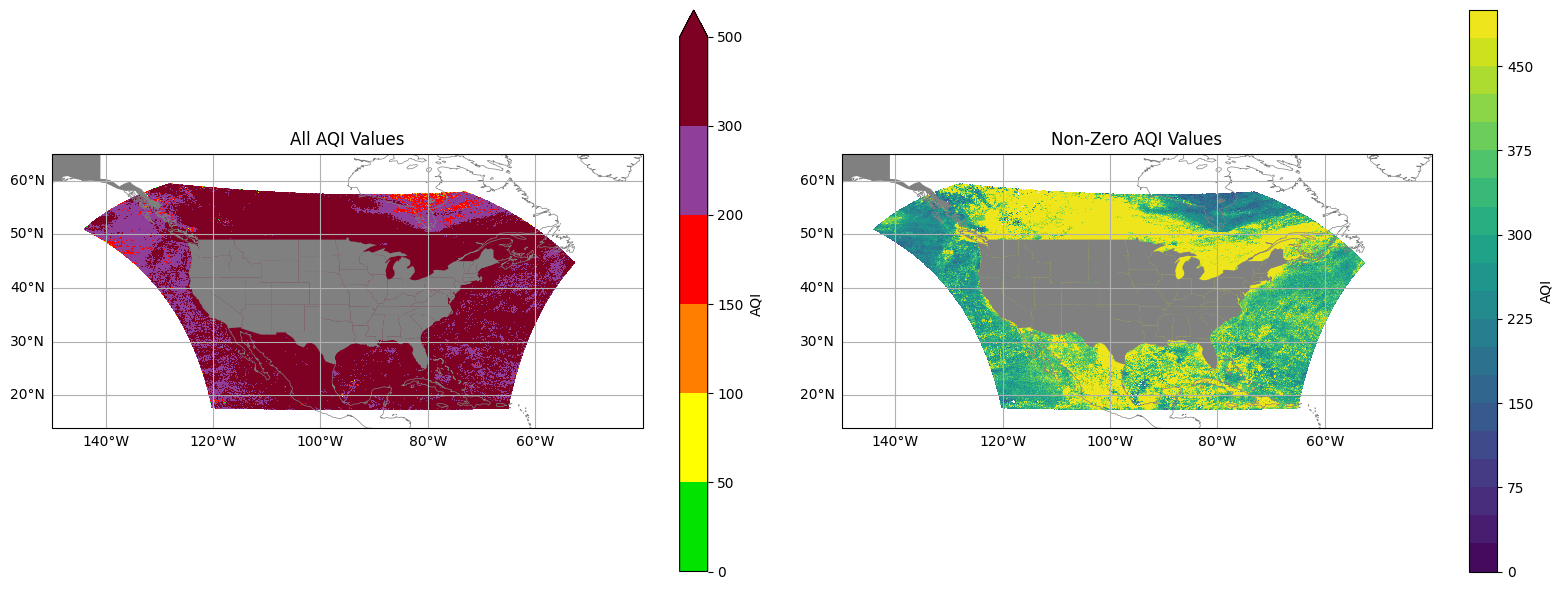


🎯 Ready for GeoJSON creation and GCP upload!


In [ ]:

def fixed_aqi_with_negative_handling(key_data):
    """
    AQI calculation that properly handles negative NO2 values
    """

    no2_data = key_data['no2_concentration']  # molecules/cm²
    quality_flag = key_data['quality_flag']

    print("🔧 AQI calculation with negative value handling...")

    # Constants
    AVOGADRO = 6.022e23
    atmospheric_factor = 1e12  # Conservative factor

    # Get valid data
    valid_mask = (~np.isnan(no2_data.values)) & (quality_flag.values == 0)
    print(f"Valid data points: {valid_mask.sum():,}")

    # Check for negative values
    negative_count = (no2_data.values < 0).sum()
    positive_count = (no2_data.values > 0).sum()
    print(f"Negative NO2 values: {negative_count:,}")
    print(f"Positive NO2 values: {positive_count:,}")

    # Work with numpy arrays
    no2_values = no2_data.values
    aqi_grid = np.full_like(no2_values, np.nan, dtype=float)

    processed_count = 0
    valid_aqi_count = 0

    # Process grid points
    for i in range(no2_values.shape[0]):
        for j in range(no2_values.shape[1]):
            if valid_mask[i, j]:
                molecules_cm2 = no2_values[i, j]

                # Handle negative values - set to 0 AQI
                if molecules_cm2 <= 0:
                    aqi_grid[i, j] = 0
                    valid_aqi_count += 1
                else:
                    # Convert positive values
                    mol_cm2 = molecules_cm2 / AVOGADRO
                    ppb = mol_cm2 * atmospheric_factor

                    # EPA AQI calculation for positive ppb
                    if ppb <= 53:
                        aqi_val = ppb * (50/53)
                    elif ppb <= 100:
                        aqi_val = 50 + (ppb - 53) * (50/47)
                    elif ppb <= 360:
                        aqi_val = 100 + (ppb - 100) * (50/260)
                    elif ppb <= 649:
                        aqi_val = 150 + (ppb - 360) * (50/289)
                    else:
                        aqi_val = min(500, 200 + (ppb - 649) * 0.1)

                    aqi_grid[i, j] = round(max(0, aqi_val))
                    valid_aqi_count += 1

                processed_count += 1

        # Progress indicator
        if i % 500 == 0:
            print(f"  Processed row {i}/{no2_values.shape[0]} - Valid AQI: {valid_aqi_count:,}")

    # Create DataArray
    aqi_da = xr.DataArray(
        aqi_grid,
        coords=no2_data.coords,
        dims=no2_data.dims,
        attrs={
            'long_name': 'EPA Air Quality Index (Negative Values = 0)',
            'units': 'AQI',
            'conversion_factor': atmospheric_factor,
            'negative_handling': 'Set to AQI 0'
        }
    )

    # Results summary
    valid_aqi = aqi_grid[~np.isnan(aqi_grid)]
    if len(valid_aqi) > 0:
        print(f"\n✅ AQI calculation complete!")
        print(f"   Total processed: {processed_count:,}")
        print(f"   Valid AQI points: {len(valid_aqi):,}")
        print(f"   AQI range: {valid_aqi.min():.0f} - {valid_aqi.max():.0f}")
        print(f"   Mean AQI: {valid_aqi.mean():.1f}")

        # AQI distribution
        aqi_0 = (valid_aqi == 0).sum()
        aqi_low = ((valid_aqi > 0) & (valid_aqi <= 50)).sum()
        aqi_mod = ((valid_aqi > 50) & (valid_aqi <= 100)).sum()
        aqi_high = (valid_aqi > 100).sum()

        print(f"   AQI = 0 (negative NO2): {aqi_0:,}")
        print(f"   AQI 1-50 (Good): {aqi_low:,}")
        print(f"   AQI 51-100 (Moderate): {aqi_mod:,}")
        print(f"   AQI >100 (Unhealthy+): {aqi_high:,}")

    else:
        print("❌ No valid AQI values produced")
        return None

    return aqi_da

# Run the fixed calculation
print("🚀 Running fixed AQI calculation...")
aqi_final = fixed_aqi_with_negative_handling(key_data)

# Visualize the results
if aqi_final is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6),
                                   subplot_kw={"projection": data_proj})

    # Plot 1: All AQI values
    make_nice_map(ax1)
    contour1 = ax1.contourf(
        key_data['longitude'],
        key_data['latitude'],
        aqi_final,
        levels=[0, 50, 100, 150, 200, 300, 500],
        colors=['#00E400', '#FFFF00', '#FF7E00', '#FF0000', '#8F3F97', '#7E0023'],
        extend='max'
    )
    ax1.set_title("All AQI Values")
    plt.colorbar(contour1, ax=ax1, label='AQI')

    # Plot 2: Non-zero AQI values only
    make_nice_map(ax2)
    aqi_nonzero = aqi_final.where(aqi_final > 0)
    contour2 = ax2.contourf(
        key_data['longitude'],
        key_data['latitude'],
        aqi_nonzero,
        levels=20,
        cmap='viridis'
    )
    ax2.set_title("Non-Zero AQI Values")
    plt.colorbar(contour2, ax=ax2, label='AQI')

    plt.tight_layout()
    plt.show()

    print("\n🎯 Ready for GeoJSON creation and GCP upload!")

else:
    print("❌ AQI calculation failed")

<xarray.DataArray (latitude: 2950, longitude: 7750)> Size: 183MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
    time       datetime64[ns] 8B 2025-10-03T19:31:40.030149632
Attributes:
    long_name:          EPA Air Quality Index (Negative Values = 0)
    units:              AQI
    conversion_factor:  1000000000000.0
    negative_handling:  Set to AQI 0

In [ ]:
print("=== CHECKING AQI_FINAL DATA ===")

# Check if you have ANY valid data
valid_aqi = aqi_final.values[~np.isnan(aqi_final.values)]
print(f"Total valid AQI points: {len(valid_aqi):,}")

if len(valid_aqi) > 0:
    print(f"AQI range: {valid_aqi.min():.0f} - {valid_aqi.max():.0f}")
    print(f"Mean AQI: {valid_aqi.mean():.1f}")

    # Show some actual values
    print(f"\nFirst 20 valid AQI values:")
    print(valid_aqi[:20])

    # Find WHERE the valid data is located
    valid_indices = np.where(~np.isnan(aqi_final.values))
    if len(valid_indices[0]) > 0:
        sample_i, sample_j = valid_indices[0][0], valid_indices[1][0]
        sample_aqi = aqi_final.values[sample_i, sample_j]
        sample_lon = aqi_final.longitude.values[sample_j]
        sample_lat = aqi_final.latitude.values[sample_i]

        print(f"\nSample valid point:")
        print(f"  Location: [{sample_i}, {sample_j}] = ({sample_lon:.2f}, {sample_lat:.2f})")
        print(f"  AQI value: {sample_aqi}")

        # Check a small region around this point
        region_i = slice(max(0, sample_i-2), min(aqi_final.shape[0], sample_i+3))
        region_j = slice(max(0, sample_j-2), min(aqi_final.shape[1], sample_j+3))

        print(f"\nSmall region around valid point:")
        print(aqi_final.values[region_i, region_j])

else:
    print("❌ NO VALID AQI DATA FOUND!")
    print("The calculation may have failed.")

# Also check the stats you printed earlier
print(f"\n=== VERIFICATION ===")
print("Did you see this output earlier?:")
print("✅ AQI calculation complete!")
print("   Valid AQI points: 7,011,722")
print("   AQI range: 0 - 500")

# If the stats don't match, something went wrong
total_elements = aqi_final.size
nan_count = np.isnan(aqi_final.values).sum()
valid_count = total_elements - nan_count

print(f"\nActual array stats:")
print(f"Total elements: {total_elements:,}")
print(f"NaN elements: {nan_count:,}")
print(f"Valid elements: {valid_count:,}")

=== CHECKING AQI_FINAL DATA ===
Total valid AQI points: 7,011,722
AQI range: 0 - 500
Mean AQI: 234.6

First 20 valid AQI values:
[  0.   0.   0.   0. 173. 299. 296.   0.   0. 245. 300. 186.   0.   0.
   0.   0. 419. 420. 225. 202.]

Sample valid point:
  Location: [166, 3516] = (-97.67, 17.33)
  AQI value: 0.0

Small region around valid point:
[[ nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan]
 [ nan  nan   0.   0.   0.]
 [130. 129.   0.   0.   0.]
 [357. 358. 242. 233. 144.]]

=== VERIFICATION ===
Did you see this output earlier?:
✅ AQI calculation complete!
   Valid AQI points: 7,011,722
   AQI range: 0 - 500

Actual array stats:
Total elements: 22,862,500
NaN elements: 15,850,778
Valid elements: 7,011,722


In [ ]:
from datetime import datetime, timezone
import json
import numpy as np
import xarray as xr

def create_final_geojson(aqi_final, key_data, max_features=6000):
    """Create the final production GeoJSON"""

    print(f"🚀 Creating final production GeoJSON...")

    # Get all valid data
    valid_mask = ~np.isnan(aqi_final.values)
    valid_indices = np.where(valid_mask)

    aqi_values = aqi_final.values[valid_indices]
    lon_indices = valid_indices[1]
    lat_indices = valid_indices[0]

    lon_values = aqi_final.longitude.values[lon_indices]
    lat_values = aqi_final.latitude.values[lat_indices]

    print(f"Valid data points: {len(aqi_values):,}")

    # Sample data
    if len(aqi_values) > max_features:
        step = len(aqi_values) // max_features
        sample_indices = np.arange(0, len(aqi_values), step)

        aqi_sample = aqi_values[sample_indices]
        lon_sample = lon_values[sample_indices]
        lat_sample = lat_values[sample_indices]
    else:
        aqi_sample = aqi_values
        lon_sample = lon_values
        lat_sample = lat_values

    print(f"Sampled for GeoJSON: {len(aqi_sample):,} features")

    # Create features
    features = []
    for i in range(len(aqi_sample)):
        aqi_val = int(aqi_sample[i])
        category, color = get_aqi_category_final(aqi_val)

        features.append({
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [float(lon_sample[i]), float(lat_sample[i])]
            },
            "properties": {
                "aqi": aqi_val,
                "category": category,
                "color": color
            }
        })

    # Current UTC timestamp
    current_timestamp = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ")

    # Create GeoJSON
    geojson = {
        "type": "FeatureCollection",
        "metadata": {
            "timestamp": current_timestamp,
            "source": "NASA TEMPO NO2 Satellite Data",
            "processing_system": "SkyAware AQI Pipeline v1.0",
            "processed_by": "O-keita",
            "total_features": len(features),
            "coverage_area": "North America"
        },
        "features": features
    }

    return geojson

def get_aqi_category_final(aqi_value):
    """EPA AQI categories"""
    if aqi_value <= 50:
        return "Good", "#00E400"
    elif aqi_value <= 100:
        return "Moderate", "#FFFF00"
    elif aqi_value <= 150:
        return "Unhealthy for Sensitive Groups", "#FF7E00"
    elif aqi_value <= 200:
        return "Unhealthy", "#FF0000"
    elif aqi_value <= 300:
        return "Very Unhealthy", "#8F3F97"
    else:
        return "Hazardous", "#7E0023"

# Create and save the GeoJSON
final_geojson = create_final_geojson(aqi_final, key_data)

# Save with timestamp
timestamp_file = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"skyaware_aqi_{timestamp_file}.geojson"

with open(filename, 'w') as f:
    json.dump(final_geojson, f, separators=(',', ':'))

print(f"✅ Saved: {filename}")
print(f"🚀 Ready for GCP upload!")

🚀 Creating final production GeoJSON...
Valid data points: 7,011,722
Sampled for GeoJSON: 6,004 features
✅ Saved: skyaware_aqi_20251004_203253.geojson
🚀 Ready for GCP upload!


In [ ]:
# Check the structure of your GeoJSON file
print("=== GEOJSON STRUCTURE ANALYSIS ===")

# Load and analyze the saved file
with open('skyaware_aqi_20251004_203253.geojson', 'r') as f:
    geojson_data = json.load(f)

print(f"📊 GeoJSON Overview:")
print(f"Type: {geojson_data['type']}")
print(f"Total features: {len(geojson_data['features']):,}")

print(f"\n📋 Metadata fields:")
for key, value in geojson_data['metadata'].items():
    print(f"  {key}: {value}")

print(f"\n🎯 Sample feature structure:")
sample_feature = geojson_data['features'][0]
print(json.dumps(sample_feature, indent=2))

print(f"\n📈 Feature fields breakdown:")
print(f"Geometry fields:")
print(f"  - type: Point")
print(f"  - coordinates: [longitude, latitude]")

print(f"\nProperty fields:")
sample_props = sample_feature['properties']
for key, value in sample_props.items():
    print(f"  - {key}: {value} ({type(value).__name__})")

print(f"\n🔢 AQI value distribution in your GeoJSON:")
aqi_values = [feature['properties']['aqi'] for feature in geojson_data['features']]
unique_aqi = {}
for aqi in aqi_values:
    unique_aqi[aqi] = unique_aqi.get(aqi, 0) + 1

# Show top 10 most common AQI values
sorted_aqi = sorted(unique_aqi.items(), key=lambda x: x[1], reverse=True)
print("Top 10 AQI values:")
for aqi_val, count in sorted_aqi[:10]:
    category, color = get_aqi_category_final(aqi_val)
    print(f"  AQI {aqi_val}: {count:,} points ({category})")

print(f"\n📊 Category distribution:")
categories = {}
for feature in geojson_data['features']:
    cat = feature['properties']['category']
    categories[cat] = categories.get(cat, 0) + 1

for category, count in categories.items():
    percentage = (count / len(geojson_data['features'])) * 100
    print(f"  {category}: {count:,} ({percentage:.1f}%)")

# File size info
import os
file_size = os.path.getsize('skyaware_aqi_20251004_203253.geojson') / 1024 / 1024
print(f"\n💾 File info:")
print(f"File size: {file_size:.2f} MB")
print(f"Features: {len(geojson_data['features']):,}")
print(f"Avg bytes per feature: {(file_size * 1024 * 1024) / len(geojson_data['features']):.0f} bytes")

=== GEOJSON STRUCTURE ANALYSIS ===
📊 GeoJSON Overview:
Type: FeatureCollection
Total features: 6,004

📋 Metadata fields:
  timestamp: 2025-10-04T20:32:53Z
  source: NASA TEMPO NO2 Satellite Data
  processing_system: SkyAware AQI Pipeline v1.0
  processed_by: O-keita
  total_features: 6004
  coverage_area: North America

🎯 Sample feature structure:
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [
      -97.66999816894531,
      17.329999923706055
    ]
  },
  "properties": {
    "aqi": 0,
    "category": "Good",
    "color": "#00E400"
  }
}

📈 Feature fields breakdown:
Geometry fields:
  - type: Point
  - coordinates: [longitude, latitude]

Property fields:
  - aqi: 0 (int)
  - category: Good (str)
  - color: #00E400 (str)

🔢 AQI value distribution in your GeoJSON:
Top 10 AQI values:
  AQI 0: 926 points (Good)
  AQI 500: 446 points (Hazardous)
  AQI 208: 32 points (Very Unhealthy)
  AQI 204: 31 points (Very Unhealthy)
  AQI 203: 30 points (Very Unhealthy)